In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

def load_data(yawn_dir, no_yawn_dir, img_size=(64, 64)):
    """
    Load images from directories and prepare them for training.
    
    Args:
        yawn_dir (str): Path to directory containing yawn images
        no_yawn_dir (str): Path to directory containing no_yawn images
        img_size (tuple): Target size for resizing images
        
    Returns:
        X (numpy array): Image data
        y (numpy array): Labels
    """
    data = []
    labels = []
    
    # Load yawn images
    for img_file in os.listdir(yawn_dir):
        img_path = os.path.join(yawn_dir, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is not None:
            img = cv2.resize(img, img_size)
            data.append(img)
            labels.append(1)  # Label for yawn
    
    # Load no_yawn images
    for img_file in os.listdir(no_yawn_dir):
        img_path = os.path.join(no_yawn_dir, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is not None:
            img = cv2.resize(img, img_size)
            data.append(img)
            labels.append(0)  # Label for no_yawn
    
    # Convert to numpy arrays
    X = np.array(data)
    y = np.array(labels)
    
    return X, y

def preprocess_data(X, y, test_size=0.2, random_state=42):
    """
    Preprocess data for training.
    
    Args:
        X (numpy array): Image data
        y (numpy array): Labels
        test_size (float): Proportion of data to use for testing
        random_state (int): Seed for random number generator
        
    Returns:
        X_train (numpy array): Training images
        X_test (numpy array): Testing images
        y_train (numpy array): Training labels
        y_test (numpy array): Testing labels
    """
    # Reshape and normalize
    X = X.reshape(-1, 64, 64, 1).astype('float32') / 255
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=random_state)
    
    return X_train, X_test, y_train, y_test

# Set paths to your collected data
yawn_dir = 'yawn'
no_yawn_dir = 'no_yawn'

# Load data
X, y = load_data(yawn_dir, no_yawn_dir)

# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data(X, y)

# Save preprocessed data (optional but recommended)
np.savez('preprocessed_data.npz', 
         X_train=X_train, 
         X_test=X_test, 
         y_train=y_train, 
         y_test=y_test)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 6448
Testing samples: 1612


In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load preprocessed data
data = np.load('preprocessed_data.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Save the model
model.save('yawn_detection_model.h5')

2025-04-04 22:15:54.288456: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-04 22:15:54.433443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743785154.504937   48821 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743785154.525851   48821 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743785154.640933   48821 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Epoch 1/20


I0000 00:00:1743785164.780421   49317 service.cc:152] XLA service 0x7d8618007300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743785164.780454   49317 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-04-04 22:16:04.852626: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743785165.478407   49317 cuda_dnn.cc:529] Loaded cuDNN version 90300


 12/202 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5223 - loss: 0.7153 

I0000 00:00:1743785169.886263   49317 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


198/202 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7968 - loss: 0.4273

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf

# Load the trained .h5 model
model = tf.keras.models.load_model('yawn_detection_model.h5')

# Convert to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
with open('yawn_detection_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [1]:
import cv2
import dlib
import numpy as np
import time
import tensorflow as tf

# Load the trained TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path='yawn_detection_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Initialize webcam with optimized settings
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)  # Lower resolution for better performance
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
cap.set(cv2.CAP_PROP_FPS, 30)

if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

# Initialize dlib's face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor_path = "/home/dhruv/CollegeProject/Trial3/customYawndata/shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(predictor_path)

def extract_mouth(image, landmarks):
    mouth_points = []
    for i in range(48, 68):
        mouth_points.append((landmarks.part(i).x, landmarks.part(i).y))
    mouth_points = np.array(mouth_points)
    x, y, w, h = cv2.boundingRect(mouth_points)
    mouth_roi = image[y:y+h, x:x+w]
    return mouth_roi

def predict_yawn(mouth_roi):
    if mouth_roi.size == 0:
        return "Unknown"
    
    mouth_roi = cv2.resize(mouth_roi, (64, 64))
    mouth_roi = mouth_roi.reshape(1, 64, 64, 1) / 255.0
    
    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], mouth_roi.astype(np.float32))
    
    # Run inference
    interpreter.invoke()
    
    # Get output tensor
    output = interpreter.get_tensor(output_details[0]['index'])
    
    return "Yawning" if output[0][0] > 0.5 else "Not Yawning"

frame_count = 0
start_time = time.time()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read frame.")
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = detector(gray)
    
    for face in faces:
        landmarks = predictor(gray, face)
        mouth_roi = extract_mouth(gray, landmarks)
        status = predict_yawn(mouth_roi)
        
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, status, (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, 
                    (0, 255, 0) if status == "Not Yawning" else (0, 0, 255), 2)
    
    cv2.imshow('Yawn Detection', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # Calculate and print FPS
    frame_count += 1
    if frame_count % 30 == 0:
        elapsed_time = time.time() - start_time
        fps = frame_count / elapsed_time
        print(f"Approximate FPS: {fps:.2f}")

cap.release()
cv2.destroyAllWindows()

2025-03-28 10:47:22.638274: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-28 10:47:22.669748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743139042.704979    3436 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743139042.715460    3436 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743139042.740105    3436 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Approximate FPS: 7.39
Approximate FPS: 9.22
Approximate FPS: 10.20
Approximate FPS: 10.78
Approximate FPS: 11.06
Approximate FPS: 11.16
Approximate FPS: 11.36
Approximate FPS: 11.48
Approximate FPS: 11.62
Approximate FPS: 11.83
Approximate FPS: 11.97
Approximate FPS: 12.13
Approximate FPS: 12.25
Approximate FPS: 12.38
Approximate FPS: 12.48
Approximate FPS: 12.60
Approximate FPS: 12.69
Approximate FPS: 12.78
Approximate FPS: 12.86
Approximate FPS: 12.92
Approximate FPS: 12.96
Approximate FPS: 12.97
Approximate FPS: 12.98
Approximate FPS: 13.00
Approximate FPS: 13.00
Approximate FPS: 13.01
Approximate FPS: 13.05
Approximate FPS: 13.05
Approximate FPS: 13.06
Approximate FPS: 13.06
Approximate FPS: 13.04
Approximate FPS: 13.03
Approximate FPS: 13.04
Approximate FPS: 13.04
Approximate FPS: 13.04
Approximate FPS: 13.04
Approximate FPS: 13.07
Approximate FPS: 13.07
Approximate FPS: 13.08
Approximate FPS: 13.07
Approximate FPS: 13.09
Approximate FPS: 13.10
Approximate FPS: 13.11
Approximate F

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Example: Replace these with your actual true labels and predicted probabilities.
# y_true = [...]
# y_scores = [...]

# Compute the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds.
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Yawn Detection Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Optionally, save the figure as an image file.
plt.savefig('roc_curve.png')


NameError: name 'y_true' is not defined

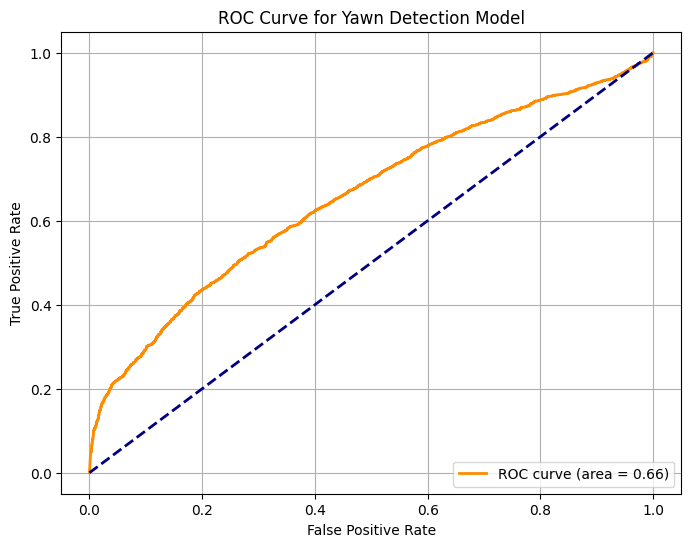

In [7]:
import numpy as np
import tensorflow as tf
import cv2
import os
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Set paths (update these paths accordingly)
model_path = "/home/dhruv/Driver_Drowsiness_detection(CNN multithreading)/models/yawn_detection_model.tflite"
yawn_dir = "/home/dhruv/Driver_Drowsiness_detection(CNN multithreading)/customYawndata/yawn/"      # Update with your actual path
no_yawn_dir = "/home/dhruv/Driver_Drowsiness_detection(CNN multithreading)/customYawndata/no_yawn/"  # Update with your actual path

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Determine expected input shape and number of channels
input_shape = input_details[0]['shape']
expected_height = input_shape[1]
expected_width = input_shape[2]
expected_channels = input_shape[3]

# Preprocessing function with grayscale conversion if needed
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Unable to read image: {img_path}")
    # Convert to grayscale if model expects 1 channel
    if expected_channels == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Resize the image
    img = cv2.resize(img, (expected_width, expected_height))
    # Normalize the image
    img = img.astype(np.float32) / 255.0
    # If grayscale, add channel dimension
    if expected_channels == 1:
        img = np.expand_dims(img, axis=-1)
    # Add batch dimension
    img = np.expand_dims(img, axis=0)
    return img

# Inference function
def predict_score(image):
    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    return float(output[0][0])  # Assuming binary output (sigmoid score)

# Collect data
y_true = []
y_scores = []

# Process yawn images (label = 1)
for file in os.listdir(yawn_dir):
    img_path = os.path.join(yawn_dir, file)
    try:
        img = preprocess_image(img_path)
        score = predict_score(img)
        y_true.append(1)
        y_scores.append(score)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

# Process no_yawn images (label = 0)
for file in os.listdir(no_yawn_dir):
    img_path = os.path.join(no_yawn_dir, file)
    try:
        img = preprocess_image(img_path)
        score = predict_score(img)
        y_true.append(0)
        y_scores.append(score)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

# Compute ROC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Yawn Detection Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
